<a href="https://colab.research.google.com/github/MANISH-KUMAR-CODES/Analysis-on-Fraud-Detection-In-Ecommerce-company/blob/main/Predict_if_Merchant_is_Fraudster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem statement**

‘XYZ’ is a large e-commerce company with its operations in several countries. As the online giant grows, so has
the number of fraudster merchants are. They deliver counterfeits or, in some cases, nothing at all. Such
schemes leave customers duped, and place both legitimate merchants and the company itself in a constant
battle to rid the marketplace of scammers. Determining this is also important in budgeting for fraud
investigation. It's a well-known problem both to the company and to merchants, which they say hasn't
effectively addressed the issue. They are serious about it and want to protect themselves from these fraudulent
merchants using technology.

You are expected to create an analytical and modelling framework to predict the Merchant Fraudulency(yes/no)
based on the quantitative and qualitative features provided in the dataset while answering other questions too
cited below.

#  **About Dataset**

Target attribute: "fraudster" (yes – 1, no – 0)

Train:

   * trainmerchantdata.csv : Merchant Information

   * trainorderdata.csv : Order Information

   * train.csv : Target Label Information

Test:

   * testmerchantdata.csv : Merchant Information

   * testorderdata.csv : Order Information

   * test.csv : Target is not available as it is to be predicted

➔ ipboundariescountries.csv : IP addresses boundaries for each country
(common for both train and test)   

# **Tasks**

### *Model Building:*

You are expected to create an analytical and modelling framework to predict the Merchant Fraudulency based
on the quantitative and qualitative features provided in the datasets. You may derive new features from the
existing features and also from the domain knowledge, which may help in improving the model efficiency.

### *Visualisation task:*

Exploratory Data Analysis using visualizations in R Notebook or Jupiter notebook format. (all train data to be
used for this task)

*  List down the insights/patterns observed from the visualizations
*  Explain the impact of most important attributes on target attribute observed from the
visualizations.

### *Observations:*

Is there any overfitting or underfitting problem? If yes, how do you address it?

### *Evaluation Metric:*

* Consider ‘F1-score’ of the fraudulent class as the error metric for classification task to tune the
model and for submissions in the tool.

### *Hints*

Both Python and R provides functions to convert IP string to numeric format which makes the number
comparison easier.


In [5]:
# Importi9ng necessary libraries
import numpy as np
import pandas as pd

# 1. Preprocessing Libraries
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder    #Dummification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    #NEW!
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold    #Hyperparameter tuning, StratifiedKFold
# another way to cross-validate
from sklearn.compose import ColumnTransformer


# 2. Algorithm Import
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# 3. Evaluation Library
from sklearn.metrics import confusion_matrix

# 4. Viz Lib
import matplotlib.pyplot as plt 
import seaborn as sns

# 5. Misc Lib
# !pip install imblearn
#from imblearn.over_sampling import SMOTE    #Data/Class imbalance
import random
random.seed(123)
import warnings
warnings.filterwarnings('ignore')

In [6]:
#Train Data Reading
merchant_train_data = pd.read_csv("train_merchant_data-1561627820784.csv", sep = ",", header = 0)
order_train_data = pd.read_csv("train_order_data-1561627847149.csv", sep = ",", header = 0)
train_data = pd.read_csv("train-1561627878332.csv", sep = ",", header = 0)
print(merchant_train_data.shape)
print(order_train_data.shape)
print(train_data.shape)


(54213, 7)
(54213, 7)
(54213, 2)


In [7]:
#Test Data Reading   
merchant_test_data = pd.read_csv("test_merchant_data-1561627903902.csv", sep = ",", header = 0)
order_test_data = pd.read_csv('test_order_data-1561627931868.csv', sep = ",", header = 0)
test_data = pd.read_csv("test-1561627952093.csv", sep = ",", header = 0)
print(merchant_test_data.shape)
print(order_test_data.shape)
print(test_data.shape)

(13554, 7)
(13554, 7)
(13554, 1)


# Understanding our data

In [8]:
# quick look at our tainning data
a = pd.DataFrame(merchant_train_data)
a.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address
0,1746213,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76
1,1746213,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169
2,1746213,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121
3,1746213,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186
4,1746213,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172


In [9]:
b= pd.DataFrame(order_train_data)
b.head()

,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Merchant_ID
0,126221,37cea9512f8d,2018-04-29 16:39:26,148,Direct,Credit Card,124231
1,115471,09f12e6efde2,2018-06-16 17:05:40,145,SEO,Credit Card,136178
2,151786,4e69e956e159,2018-10-26 18:00:46,62,Ads,Internet Banking,198611
3,140456,663443aaeb82,2018-12-12 05:41:52,28,SEO,Debit Card,127993
4,114721,99258810c121,2018-09-20 11:06:10,70,Ads,Credit Card,250146


In [10]:
c = pd.DataFrame(train_data)
c.head()

,Merchant_ID,Fraudster
0,221592,0
1,316935,1
2,38454,1
3,214437,1
4,296240,1


In [11]:
# lets merge all three dataframe on common columns and get a complete dataframe
a = a.merge(b,on = 'Merchant_ID', how='outer')
train_df = a.merge(c,on = 'Merchant_ID', how ='outer')
train_df.head()


,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
0,1746213,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0
1,1746213,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0
2,1746213,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0
3,1746213,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0
4,1746213,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0


In [12]:
print(train_df.shape, '\n')
print(train_df.dtypes)

(54213, 14) 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
dtype: object


In [13]:
# checking description of integer columns
train_df.describe(include = 'int')

,Ecommerce_Provider_ID,Merchant_ID,Age,Customer_ID,Order_Value_USD,Fraudster
count,54213.0,54213.000000,54213.000000,54213.000000,54213.000000,54213.00000
mean,1746213.0,200395.176212,33.122240,137966.285208,92.230240,0.09269
std,0.0,115398.486895,8.630091,15563.516156,45.673263,0.29000
min,1746213.0,2.000000,18.000000,111234.000000,22.000000,0.00000
25%,1746213.0,100997.000000,27.000000,124471.000000,55.000000,0.00000
50%,1746213.0,200574.000000,32.000000,137864.000000,88.000000,0.00000
75%,1746213.0,300407.000000,39.000000,151405.000000,122.000000,0.00000
max,1746213.0,399993.000000,72.000000,165000.000000,385.000000,1.00000


In [14]:
# checking description of category columns
train_df.describe(include = 'object')

,Merchant_Registration_Date,Registered_Device_ID,Gender,IP_Address,Order_ID,Date_of_Order,Order_Source,Order_Payment_Method
count,54213,54213,54213,54213,54213,54213,54213,54213
unique,54213,51291,2,52028,54213,54161,3,5
top,2018-05-01 21:15:11,RJEAMRBBMPWEA,M,91.161.239.48,3b8983a83c7b,2018-08-01 01:24:54,SEO,Credit Card
freq,1,9,31761,9,1,2,21884,21844


In [15]:
# Quick look at our test data
a1 = pd.DataFrame(merchant_test_data)
a1.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address
0,1746213,53637,2018-02-11 20:50:29,PTMLBENYMQCTV,F,40,134.162.124.62
1,1746213,243517,2018-04-06 13:19:39,HMCLDZUZPWZRR,M,39,152.76.98.87
2,1746213,343640,2018-01-12 16:47:49,VLGSMAPXISSEJ,M,23,31.202.3.255
3,1746213,69889,2018-02-19 21:58:52,ZINHISBBOKQXT,M,34,12.242.168.185
4,1746213,125706,2018-05-17 15:50:19,WFKEAOTPHTYEO,M,20,26.61.210.47


In [16]:
b1 = pd.DataFrame(order_test_data)
b1.head()

,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Merchant_ID
0,157068,a032de091f51,2018-03-09 09:09:42,60,SEO,Credit Card,53637
1,112534,0d563f0606d6,2018-06-13 20:11:19,28,SEO,Credit Card,243517
2,148774,18fb0fa888b6,2018-04-14 04:19:36,75,Ads,Debit Card,343640
3,114528,ed1eb920d721,2018-04-01 13:55:44,98,SEO,Credit Card,69889
4,120940,313dcf962627,2018-05-25 02:08:18,35,SEO,Credit Card,125706


In [17]:
c1 = pd.DataFrame(test_data)
c1.head()

,Merchant_ID
0,53637
1,243517
2,343640
3,69889
4,125706


In [18]:
# lets merge all three dataframe on common columns and get a complete dataframe
a1 = a1.merge(b1,on = 'Merchant_ID', how='outer')
test_df = a1.merge(c1,on = 'Merchant_ID', how ='outer')
test_df.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method
0,1746213,53637,2018-02-11 20:50:29,PTMLBENYMQCTV,F,40,134.162.124.62,157068,a032de091f51,2018-03-09 09:09:42,60,SEO,Credit Card
1,1746213,243517,2018-04-06 13:19:39,HMCLDZUZPWZRR,M,39,152.76.98.87,112534,0d563f0606d6,2018-06-13 20:11:19,28,SEO,Credit Card
2,1746213,343640,2018-01-12 16:47:49,VLGSMAPXISSEJ,M,23,31.202.3.255,148774,18fb0fa888b6,2018-04-14 04:19:36,75,Ads,Debit Card
3,1746213,69889,2018-02-19 21:58:52,ZINHISBBOKQXT,M,34,12.242.168.185,114528,ed1eb920d721,2018-04-01 13:55:44,98,SEO,Credit Card
4,1746213,125706,2018-05-17 15:50:19,WFKEAOTPHTYEO,M,20,26.61.210.47,120940,313dcf962627,2018-05-25 02:08:18,35,SEO,Credit Card


In [19]:
print(test_df.shape, '\n')
print(test_df.dtypes)

(13554, 13) 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
dtype: object


# Pre-Processing Data and Exploratory Data Analysis

Pre-processing steps of the Train Data will be Applied to Test Data respectively.

#### **Notes on Quantative Features**

'Merchant_ID', 'Customer_ID' will be converted to dtype 'object'.

'Ecommerce_Provider_ID' will be dropped due to No Information Gain.

In [20]:
train_df.drop(labels = 'Ecommerce_Provider_ID', axis = 1, inplace = True)
test_df.drop(labels = 'Ecommerce_Provider_ID', axis = 1, inplace = True)

In [21]:
train_df.head(5)

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
0,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0
1,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0
2,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0
3,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0
4,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0


In [33]:
train_df[['Merchant_ID', 'Customer_ID']] = train_df[['Merchant_ID', 'Customer_ID']].astype('object') 
test_df[['Merchant_ID', 'Customer_ID']] = test_df[['Merchant_ID', 'Customer_ID']].astype('object')
train_df['Date_of_Order'] = train_df['Date_of_Order'].astype('datetime64[ns]') 
test_df['Date_of_Order'] = test_df['Date_of_Order'].astype('datetime64[ns]')
train_df['Merchant_Registration_Date'] = train_df['Merchant_Registration_Date'].astype('datetime64[ns]') 
test_df['Merchant_Registration_Date'] = test_df['Merchant_Registration_Date'].astype('datetime64[ns]')
print(train_df.dtypes, '\n')
print(test_df.dtypes)

Merchant_ID                           object
Merchant_Registration_Date    datetime64[ns]
Registered_Device_ID                  object
Gender                                object
Age                                    int64
IP_Address                            object
Customer_ID                           object
Order_ID                              object
Date_of_Order                 datetime64[ns]
Order_Value_USD                        int64
Order_Source                          object
Order_Payment_Method                  object
Fraudster                              int64
country                               object
Continent                             object
Sub_Divisions                         object
City                                  object
dtype: object 

Merchant_ID                           object
Merchant_Registration_Date    datetime64[ns]
Registered_Device_ID                  object
Gender                                object
Age                                    

### Percentage Distribution of Order sources

In [23]:
train_df['Order_Source'].value_counts(normalize = True)

SEO       0.403667
Ads       0.392138
Direct    0.204195
Name: Order_Source, dtype: float64

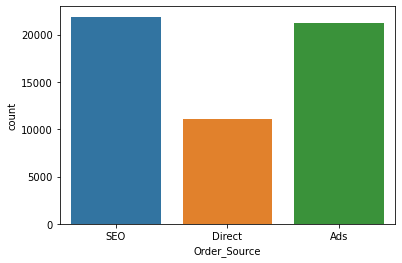

SEO       21884
Ads       21259
Direct    11070
Name: Order_Source, dtype: int64

In [24]:
sns.countplot(x='Order_Source', data=train_df)
plt.show()
train_df.Order_Source.value_counts()

Distribution of 'Age' is fairly symmetrical. Mean = 33.12, Median = 32

<AxesSubplot:xlabel='Age', ylabel='Density'>

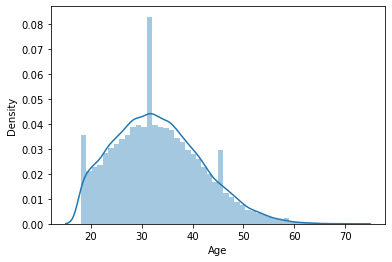

In [25]:
# Check distribution of age
# Density Curve + Histogram, shows distribution of Continuous Feature
%matplotlib inline
sns.distplot(train_df["Age"]) #NT: y is percentage count 

In [26]:
train_df['Order_Payment_Method'].value_counts(normalize = True)

Credit Card         0.402929
Internet Banking    0.243355
Debit Card          0.167303
E-wallet            0.161197
Cash On Delivery    0.025215
Name: Order_Payment_Method, dtype: float64

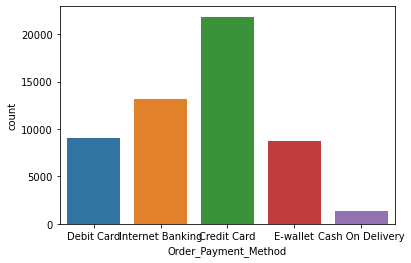

Credit Card         21844
Internet Banking    13193
Debit Card           9070
E-wallet             8739
Cash On Delivery     1367
Name: Order_Payment_Method, dtype: int64

In [27]:
sns.countplot(x='Order_Payment_Method', data=train_df)
plt.show()
train_df.Order_Payment_Method.value_counts()

### Feature Engineering

In [28]:
#!pip install maxminddb-geolite2

#### From geolite2 library we will try to get the city ,country subdivisions and continent data from the given Ip address column

In [29]:
from geolite2 import geolite2
geo = geolite2.reader()

def get_country(ip):
    try :
        x = geo.get(ip)
    except ValueError:   #Faulty or improper IP value
        return np.nan
    try:
        return x['country']['names']['en'] if x is not None else np.nan
    except KeyError: 
        return np.nan
    
def get_city(ip):
    try:
        x = geo.get(ip)
    except ValueError:   #if Value passed is faulty
        return np.nan
    
    try:
        return x['city']['names']['en'] if x is not None  else np.nan
    except KeyError:  #if Dictionary indexing is faulty 
        return np.nan

def get_subdivisions(ip):
    try:
        x = geo.get(ip)
    except ValueError:   #if Value passed is faulty
        return np.nan
    
    try:
        return x['subdivisions'][0]['names']['en'] if x is not None  else np.nan
    except KeyError:  #if Dictionary indexing is faulty 
        return np.nan

def get_continent(ip):
    try:
        x = geo.get(ip)
    except ValueError:   #if Value pafssed is faulty
        return np.nan
    
    try:
        return x['continent']['names']['en'] if x is not None  else np.nan
    except KeyError:  #if Dictionary indexing is faulty 
        return np.nan        

In [30]:
import time

s_time = time.time()
#apply(fn) applies fn. on all pd.series elements
train_df['country'] = train_df.loc[:,'IP_Address'].apply(get_country)  #Time:  41.6 s
test_df['country'] = test_df.loc[:,'IP_Address'].apply(get_country)   #Time: 7.71 s
train_df['Continent'] = train_df.loc[:,'IP_Address'].apply(get_continent)
test_df['Continent'] = test_df.loc[:,'IP_Address'].apply(get_continent)
train_df['Sub_Divisions'] = train_df.loc[:,'IP_Address'].apply(get_subdivisions)
test_df['Sub_Divisions'] = test_df.loc[:,'IP_Address'].apply(get_subdivisions)
train_df['City'] = train_df.loc[:,'IP_Address'].apply(get_city)
test_df['City'] = test_df.loc[:,'IP_Address'].apply(get_city)
# geolite2.close()
print('Time:',time.time()-s_time)

Time: 477.3271803855896


In [34]:
# first 5 rows
train_df.head(5)

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster,country,Continent,Sub_Divisions,City
0,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0,United States,North America,New Jersey,Newark
1,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0,United Kingdom,Europe,England,Maidstone
2,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0,Japan,Asia,Ishikawa,Komatsu
3,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0,Austria,Europe,NaN,NaN
4,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0,China,Asia,Zhejiang,Hangzhou


In [80]:
## Checking null values again
train_df.isnull().sum()

Merchant_ID                       0
Merchant_Registration_Date        0
Registered_Device_ID              0
Gender                            0
Age                               0
IP_Address                        0
Customer_ID                       0
Order_ID                          0
Date_of_Order                     0
Order_Value_USD                   0
Order_Source                      0
Order_Payment_Method              0
Fraudster                         0
country                        7808
Continent                      7751
Sub_Divisions                 23945
City                          24285
dtype: int64

In [83]:
print(test_df.shape)
test_df.isna().sum()

(13554, 16)


Merchant_ID                      0
Merchant_Registration_Date       0
Registered_Device_ID             0
Gender                           0
Age                              0
IP_Address                       0
Customer_ID                      0
Order_ID                         0
Date_of_Order                    0
Order_Value_USD                  0
Order_Source                     0
Order_Payment_Method             0
country                       1980
Continent                     1967
Sub_Divisions                 6122
City                          6204
dtype: int64

### Extracting date,month,year from both tainning and testing data

In [86]:
# Extracting DT info
train_df['Quarter'] = train_df['Date_of_Order'].dt.quarter
train_df['Month'] = train_df['Date_of_Order'].dt.month
train_df['Day'] = train_df['Date_of_Order'].dt.weekday
train_df['Time_Hour'] = train_df['Date_of_Order'].dt.hour
test_df['Quarter'] = test_df['Date_of_Order'].dt.quarter
test_df['Month'] = test_df['Date_of_Order'].dt.month
test_df['Day'] = test_df['Date_of_Order'].dt.weekday
test_df['Time_Hour'] = test_df['Date_of_Order'].dt.hour

In [88]:
# checking our train_df first few rows
train_df.head(5)

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,...,Order_Payment_Method,Fraudster,country,Continent,Sub_Divisions,City,Quarter,Month,Day,Time_Hour
0,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,...,Debit Card,0,United States,North America,New Jersey,Newark,3,7,0,10
1,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,...,Internet Banking,0,United Kingdom,Europe,England,Maidstone,2,6,4,11
2,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,...,Credit Card,0,Japan,Asia,Ishikawa,Komatsu,3,8,0,10
3,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,...,E-wallet,0,Austria,Europe,NaN,NaN,3,7,6,15
4,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,...,E-wallet,0,China,Asia,Zhejiang,Hangzhou,2,4,0,8


In [70]:
top_country_with_merchant = pd.DataFrame(train_df.groupby('country')['Merchant_ID'].count().\
                                         sort_values(ascending = False).reset_index())
top_country_with_merchant = top_country_with_merchant.rename(columns={'Merchant_ID':'Count'})
top_country_with_merchant.head(10)

,country,Count
0,United States,20758
1,China,4358
2,Japan,2707
3,United Kingdom,1594
4,Republic of Korea,1437
5,Germany,1435
6,France,1113
7,Brazil,1039
8,Canada,950
9,Netherlands,725


In [76]:
top_city_with_merchant = pd.DataFrame(train_df.groupby('City')['Merchant_ID'].count().\
                                         sort_values(ascending = False).reset_index())
top_city_with_merchant =top_city_with_merchant.rename(columns={'Merchant_ID':'Count'})
top_city_with_merchant.head(10)

,City,Count
0,Beijing,847
1,Tokyo,821
2,Fort Huachuca,658
3,Palo Alto,379
4,Guangzhou,324
5,Dearborn,309
6,New York,308
7,Houston,289
8,San Diego,284
9,Seoul,282
